In [2]:
# Wavefunction generation
from pyscf import mcscf, fci, lib 
from pyscf import gto, scf, tools, dft
import api as pyq 
import importlib
import os
import h5py
import pandas as pd
import pdb
import pyscf
import numpy as np
import pyqmc
import scipy
import matplotlib.pyplot as plt
from pyscf.scf.hf import dump_scf_summary
from concurrent.futures import ProcessPoolExecutor
from pyscf.scf.chkfile import dump_scf
print(pyq.__file__)
print(pyscf.__file__)

/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


/Users/ksu/Documents/GitHub/pyqmc/pyqmc/api.py
/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/__init__.py


In [155]:
# H2 molecule
def run_scf(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.;H 0. 0. 1.;", basis=f'ccecpccpvdz', unit='bohr')
    mf = scf.UHF(mol)
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm)
    dump_scf(mf.mol, 'scf.hdf5', mf.energy_tot(), mf.mo_energy, mf.mo_coeff, mf.mo_occ)
    return mf

def run_lda_be(scf_checkfile):
    print("Be atom neutral LDA spin=2")
    mol = gto.M(atom="Be 0. 0. 0.", spin=2,basis=f'ccpvdz', unit='bohr')
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")        
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_li(scf_checkfile):
    print("Li atom neutral LDA spin=1")
    mol = gto.M(atom="Li 0. 0. 0.",basis=f'ccpvtz', spin=1, unit='bohr')
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")    
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_he(scf_checkfile):
    print("He atom neutral LDA spin=0")
    # mol = gto.M(atom="He 0. 0. 0.", basis="ccECP_cc-pVDZ", ecp="ccecp", unit='bohr')
    mol = gto.M(atom="He 0. 0. 0.", basis="ccpvdz", unit='bohr')    
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")    
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_h2(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.; H 0. 0. 2", spin = 2, basis=f'ccecpccpvdz', unit='bohr')
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.xc='LDA, VWN'
    mf.kernel()    
    # mf.kernel(dm, xc='LDA,VWN')
    return mf

def run_lda(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.", spin=1,basis=f'ccecpccpvdz', unit='bohr')
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf
    
def run_casscf(scf_checkfile, ci_checkfile):
    cell, mf = pyq.recover_pyscf(scf_checkfile, cancel_outputs=False)
    mc = mcscf.CASSCF(mf,2,2)
    mc.chkfile = ci_checkfile
    mc.kernel()
    with h5py.File(mc.chkfile, "a") as f:
        print("Available output from CASSCF:", f["mcscf"].keys())
        f["mcscf/nelecas"] = list(mc.nelecas)
        f["mcscf/ci"] = mc.ci
    return mc

def run_casci(scf_checkfile, ci_checkfile):
    cell, mf = pyq.recover_pyscf(scf_checkfile, cancel_outputs=False)
    # ncas: orbitals
    # nelecas: electrons
    ncas = 4
    nelecas = 2
    mc = mcscf.CASCI(mf, ncas, nelecas)
    mc.kernel()
    print(mc.__dict__.keys())
    with h5py.File(ci_checkfile, "a") as f:
        f.create_group("ci")
        f["ci/ncas"] = mc.ncas
        f["ci/nelecas"] = list(mc.nelecas)
        f["ci/ci"] = mc.ci
        f["ci/mo_coeff"] = mc.mo_coeff
        print("Available output from CASCI:", f["ci"].keys())
    return mc

def make_wf_object(scf_checkfile, ci_checkfile):
    mol, mf, mc = pyq.recover_pyscf(scf_checkfile, ci_checkfile=ci_checkfile)
    wf, _ = pyq.generate_wf(mol, mf, mc=mc)
    return wf

def stat_qmc(etot, filename):
    block_sizes = np.linspace(2,len(etot[discard:])//16, 10, dtype=int)
    reblocks = [len(etot)//s for s in block_sizes]

    plt.figure()
    df = pd.DataFrame([pyq.read_mc_output(filename, warmup=discard, reblock=reblock) for reblock in reblocks])
    df['block_size'] = block_sizes
    plt.plot("block_size",'energytotal_err',data=df, marker='o')
    plt.xlabel("Block size")
    plt.ylabel("Estimated uncertainty (Ha)")

def reblock(e, discard, reblock_size):
    e = e[discard:]
    vals = pyqmc.reblock.reblock(e,int(len(e)/reblock_size))
    # import pdb
    # pdb.set_trace()
    
    e_m  = np.mean(vals, axis=0)
    e_d  = scipy.stats.sem(vals, axis=0)    
    return e, e_m, e_d

scf_checkfile = "scf.hdf5"
ci_checkfile = "ci.hdf5"
# mf = run_scf(scf_checkfile)
mf_lda = run_lda_he(scf_checkfile)

# mc = run_casci(scf_checkfile, ci_checkfile)

He atom neutral LDA spin=0
HF
converged SCF energy = -2.85516047724274  <S^2> = 0  2S+1 = 1
LDA
converged SCF energy = -2.82670655418611  <S^2> = 4.4408921e-16  2S+1 = 1


In [156]:
tstep = 0.001
nconfig = 2000
nsteps = 1000
discard = 100
reblock_size = 50

In [157]:
import importlib, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
import pyqmc.pyscftools as pyscftools
from accumulators import ABQMCEnergyAccumulator

def initialize_boson_qmc_objects(
    dft_checkfile,
):  
    mol, mf = pyscftools.recover_pyscf(scf_checkfile)
    wf, to_opt = wftools.generate_boson_wf(
        mol, mf, jastrow = None
    )
    return wf

def initialize_qmc_objects(
    dft_checkfile: str,
):
    mol, mf = pyscftools.recover_pyscf(dft_checkfile)
    wf, to_opt = wftools.generate_wf(
        mol, mf, jastrow=None
    )
    return wf


Text(0.5, 1.0, 'Total value 100 configurations')

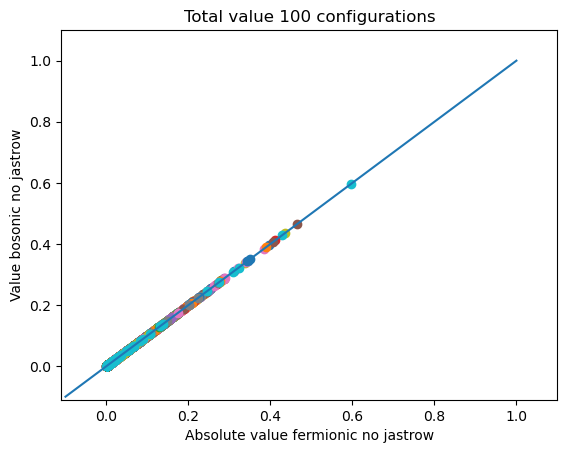

In [158]:
# Total value
trials = 100
for i in range(trials):
    nconfig = 100
    mol, mf = pyscftools.recover_pyscf(scf_checkfile)
    configs = mc.initial_guess(mol, nconfig)
    wfb = initialize_boson_qmc_objects(
        scf_checkfile,
    )
    wf = initialize_qmc_objects(
            scf_checkfile,
        )
    e=0
    sign, val = wf.recompute(configs)
    # g1, val2, (aograd, mograd) = wf.gradient_value(e, configs.electron(e))  
    # grad = - limdrift(np.real(g1.T))
    e=0
    signb, valb = wfb.recompute(configs)
    # g1b, valb2, (aogradb, mogradb) = wfb.gradient_value(e, configs.electron(e))
    # gradb = - limdrift(np.real(g1b.T))
    plt.scatter(np.exp(val), valb)
    # plt.scatter(grad,gradb/np.tile(valb, (3,1)).T)
    # plt.scatter(g1,g1b/np.tile(valb, (3,1)))
    
xmin = -0.1
xmax = 1
x = np.linspace(xmin, xmax, 100)
plt.plot(x,x)
plt.xlim((xmin*1.1, xmax*1.1))
plt.ylim((xmin*1.1, xmax*1.1))
plt.ylabel('Value bosonic no jastrow')
plt.xlabel('Absolute value fermionic no jastrow')
plt.title('Total value '+ str(trials) + ' configurations')

Text(0.5, 1.0, "100 configurations before Umrigar's limdrift")

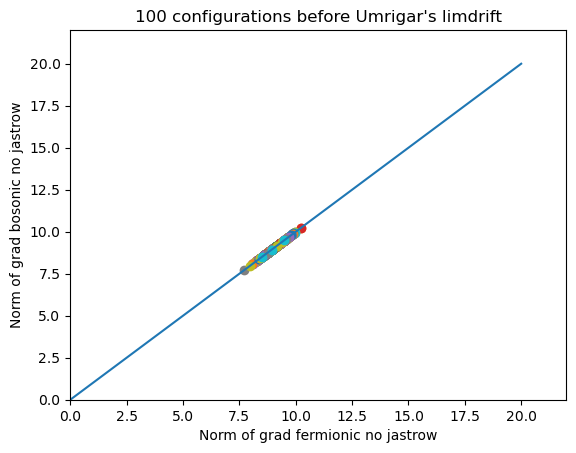

In [262]:
trials = 100
for i in range(trials):
    nconfig = 100
    mol, mf = pyscftools.recover_pyscf(scf_checkfile)
    configs = mc.initial_guess(mol, nconfig)
    wfb = initialize_boson_qmc_objects(
        scf_checkfile,
    )
    wf = initialize_qmc_objects(
            scf_checkfile,
        )
    e=0
    sign, val = wf.recompute(configs)
    g1, val2, (aograd, mograd) = wf.gradient_value(e, configs.electron(e))  
    # grad = - limdrift(np.real(g1.T))
    e=0
    signb, valb = wfb.recompute(configs)
    g1b, valb2, (aogradb, mogradb) = wfb.gradient_value(e, configs.electron(e))
    # gradb = - limdrift(np.real(g1b.T))
    # plt.scatter(np.exp(val), valb)
    # plt.scatter(grad,gradb/np.tile(valb, (3,1)).T)
    lngrad = np.linalg.norm(g1, axis=1)
    lngradb = np.linalg.norm(g1b/np.tile(valb, (3,1)), axis=1)
    plt.scatter(lngrad,lngradb)
    # plt.scatter(g1.flatten(),(g1b/np.tile(valb, (3,1))).flatten())
xmin = 0
xmax = 20
x = np.linspace(xmin, xmax, 100)
plt.plot(x,x)
plt.xlim((xmin*1.1, xmax*1.1))
plt.ylim((xmin*1.1, xmax*1.1))
plt.ylabel('Norm of grad bosonic no jastrow')
plt.xlabel('Norm of grad fermionic no jastrow')
plt.title(str(trials) + ' configurations before Umrigar\'s limdrift')

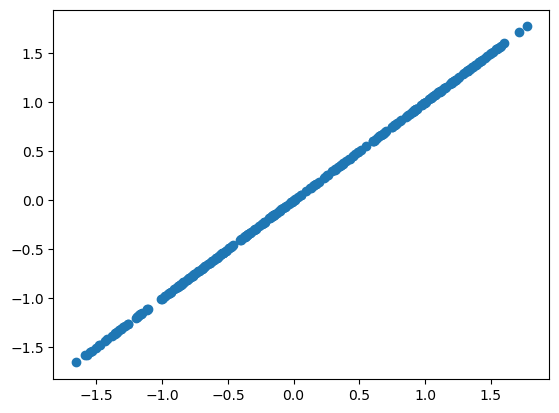

In [263]:
gg = g1
ggb = g1b/np.tile(valb, (3,1))

plt.scatter(gg, ggb)

Text(0.5, 1.0, "100 configurations after Umrigar's limdrift (using L. Wagner version)")

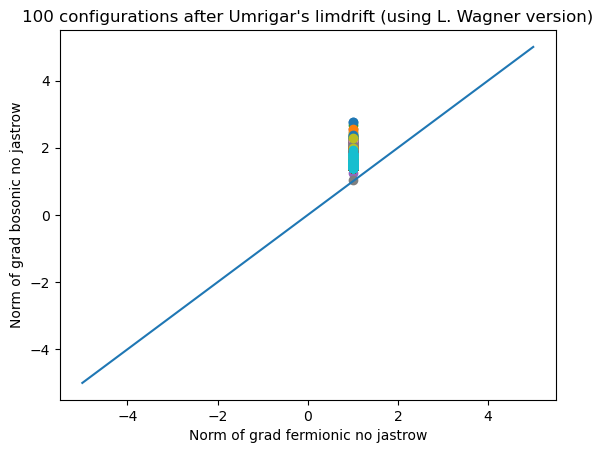

In [269]:
# L. Wagner limdrift to both
import pdb
trials = 100
for i in range(trials):
    nconfig = 100
    mol, mf = pyscftools.recover_pyscf(scf_checkfile)
    configs = mc.initial_guess(mol, nconfig)
    wfb = initialize_boson_qmc_objects(
        scf_checkfile,
    )
    wf = initialize_qmc_objects(
            scf_checkfile,
        )
    e=0
    sign, val = wf.recompute(configs)
    g1, val2, (aograd, mograd) = wf.gradient_value(e, configs.electron(e))  
    aa = g1.copy()
    grad = - limdrift(np.real(g1.T))[0]
    e=0
    signb, valb = wfb.recompute(configs)
    g1b, valb2, (aogradb, mogradb) = wfb.gradient_value(e, configs.electron(e))
    gradb = - limdrift(np.real(g1b.T))[0]
    # plt.scatter(np.exp(val), valb)
    plt.scatter(np.linalg.norm(grad, axis=1),np.linalg.norm((gradb/np.tile(valb, (3,1)).T), axis=1))
    # plt.scatter(g1,g1b/np.tile(valb, (3,1)))
xmin = -5
xmax = 5
x = np.linspace(xmin, xmax, 100)
plt.plot(x,x)
plt.xlim((xmin*1.1, xmax*1.1))
plt.ylim((xmin*1.1, xmax*1.1))
plt.xlabel('Norm of grad fermionic no jastrow')
plt.ylabel('Norm of grad bosonic no jastrow')
plt.title(str(trials) + ' configurations after Umrigar\'s limdrift (using L. Wagner version)')

In [291]:
e=0
sign, val = wf.recompute(configs)
g1, val2, (aograd, mograd) = wf.gradient_value(e, configs.electron(e))  
g = g1.T
tot = np.linalg.norm(g, axis=1)
mask = tot>1

In [292]:
g1.T.shape

(100, 3)

In [293]:
tot.shape

(100,)

In [295]:
np.linalg.norm(g[mask, :] / tot[mask, np.newaxis], axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [304]:
e=0
signb, valb = wfb.recompute(configs)
g1b, valb2, (aogradb, mogradb) = wfb.gradient_value(e, configs.electron(e))
gb = g1b.T/np.tile(valb, (3,1)).T
totb = np.linalg.norm(gb, axis=1)
maskb = totb>1

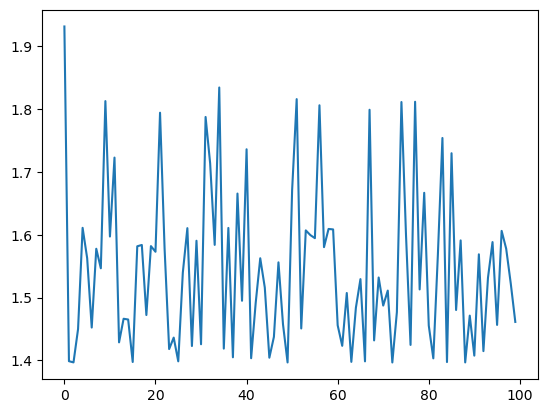

In [305]:
plt.plot(totb)

In [302]:
gb/np.tile(valb, (3,1)).T

array([[ 0.894333  , -0.63939802, -1.58803663],
       [-0.5792883 , -0.30970025,  1.234979  ],
       [-0.04946302,  0.357664  ,  1.34941767],
       [ 0.80335181,  1.1563841 ,  0.34589281],
       [ 1.4891094 ,  0.28814307, -0.54308232],
       [-0.13741251, -0.37219907,  1.51157564],
       [-0.45385809, -1.04273503,  0.90333203],
       [-1.20828434,  0.72117914,  0.71354329],
       [ 0.45877674, -0.18348693, -1.46560106],
       [-1.70834269,  0.01510949,  0.60602038],
       [ 1.58373715,  0.08363362, -0.18921237],
       [ 0.37037613,  0.51915836,  1.60043453],
       [-0.07222884, -1.41189154, -0.20680968],
       [ 0.8497094 ,  1.19262759,  0.07592874],
       [-0.60047739, -1.32072414,  0.2042512 ],
       [-0.0584733 , -0.03192218, -1.39594811],
       [-1.01712655, -1.01894128, -0.65487009],
       [-0.18202487, -1.56466812,  0.16440616],
       [ 1.06247208,  1.01794516, -0.05018412],
       [ 1.55427618,  0.22798418, -0.18652341],
       [-1.55673233, -0.19571659,  0.111

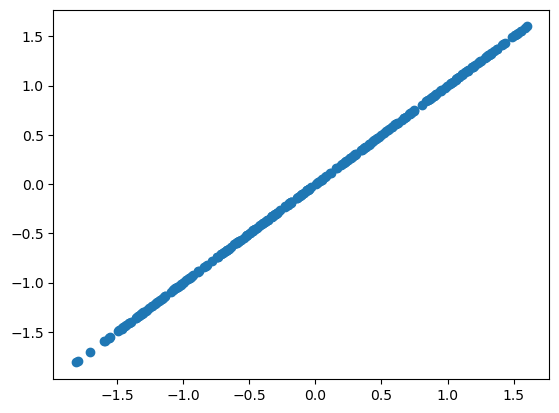

In [283]:
gg = g1
ggb = g1b/np.tile(valb, (3,1))

plt.scatter(gg, ggb)

In [311]:
def limdrift(g, cutoff=1):
    """
    Limit a vector to have a maximum magnitude of cutoff while maintaining direction

    :parameter g: a [nconf,ndim] vector
    :parameter cutoff: the maximum magnitude
    :returns: The vector with the cutoff applied.
    """
    tot = np.linalg.norm(g, axis=1)
    mask = tot > cutoff
    g[mask, :] = cutoff * g[mask, :] / tot[mask, np.newaxis]
    return g

def limdrift2(g, val, cutoff=1):
    """
    Limit a vector to have a maximum magnitude of cutoff while maintaining direction

    :parameter g: a [nconf,ndim] vector
    :parameter cutoff: the maximum magnitude
    :returns: The vector with the cutoff applied.
    """
    # grat = g/np.tile(val, (3,1)).T
    
    tot = np.linalg.norm(g, axis=1)
    mask = tot > cutoff
    g[mask, :] = cutoff * g[mask, :] / tot[mask, np.newaxis]
    # g = grat*np.tile(val, (3,1)).T
    return g, mask

Text(0.5, 1.0, "1 configurations after Umrigar's limdrift (using modified version)")

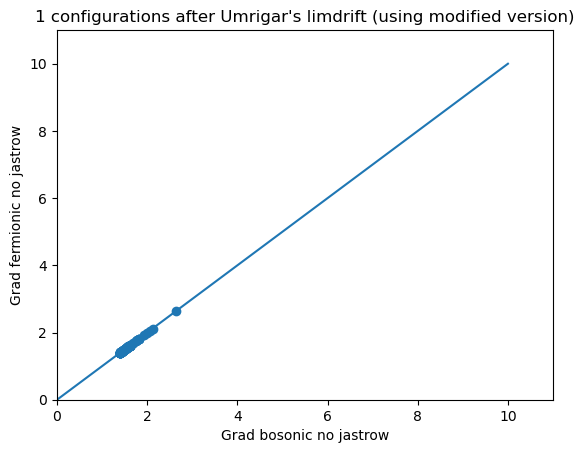

In [314]:
import pdb
trials = 1
for i in range(trials):
    nconfig = 100
    mol, mf = pyscftools.recover_pyscf(scf_checkfile)
    configs = mc.initial_guess(mol, nconfig, seed = 100)
    wfb = initialize_boson_qmc_objects(
        scf_checkfile,
    )
    wf = initialize_qmc_objects(
            scf_checkfile,
        )
    e=0
    sign, val = wf.recompute(configs)
    g1, val2, (aograd, mograd) = wf.gradient_value(e, configs.electron(e))  
    grad = - limdrift(np.real(g1.T), cutoff = 100)    
    
    e=0
    signb, valb = wfb.recompute(configs)
    g1b, valb2, (aogradb, mogradb) = wfb.gradient_value(e, configs.electron(e))
    
    ln_g1b = g1b/np.tile(valb, (3,1))
    limdb = limdrift(np.real(ln_g1b.T), cutoff = 100)
    gradb = - limdb * np.tile(valb, (3,1)).T
    

    # plt.scatter(np.exp(val), valb)
    g_norm = np.linalg.norm(grad, axis=1)
    gb_norm = np.linalg.norm((gradb/np.tile(valb, (3,1)).T), axis=1)
    plt.scatter(g_norm, gb_norm)
    # plt.scatter(g1,g1b/np.tile(valb, (3,1)))
xmin = 0
xmax = 10
x = np.linspace(xmin, xmax, 100)
plt.plot(x,x)
plt.xlim((xmin*1.1, xmax*1.1))
plt.ylim((xmin*1.1, xmax*1.1))
plt.xlabel('Grad bosonic no jastrow')
plt.ylabel('Grad fermionic no jastrow')
plt.title(str(trials) + ' configurations after Umrigar\'s limdrift (using modified version)')

In [260]:
gg = g1
ggb = g1b/np.tile(valb, (3,1))

plt.scatter(gg, ggb)
# tot = np.linalg.norm(np.real(g1.T), axis=1)
# b_tot = np.linalg.norm(np.real(g1b.T)/np.tile(valb, (3,1)).T, axis=1)

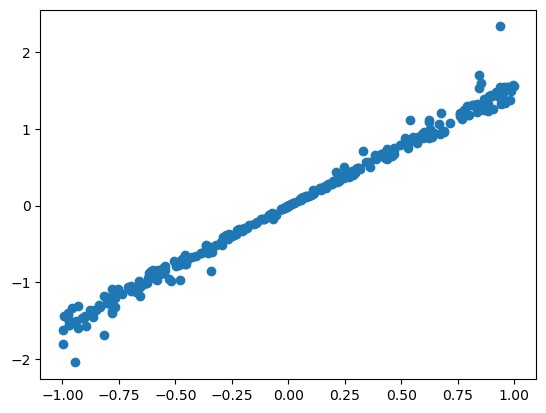

In [240]:
np.tile(valb, (3, 1)).T

array([[7.45455506e-03, 7.45455506e-03, 7.45455506e-03],
       [7.09672718e-02, 7.09672718e-02, 7.09672718e-02],
       [2.79300950e-02, 2.79300950e-02, 2.79300950e-02],
       [3.21967207e-03, 3.21967207e-03, 3.21967207e-03],
       [1.92505940e-02, 1.92505940e-02, 1.92505940e-02],
       [1.33188814e-02, 1.33188814e-02, 1.33188814e-02],
       [2.50423570e-03, 2.50423570e-03, 2.50423570e-03],
       [5.28887242e-03, 5.28887242e-03, 5.28887242e-03],
       [3.03998727e-03, 3.03998727e-03, 3.03998727e-03],
       [2.13540454e-02, 2.13540454e-02, 2.13540454e-02],
       [1.37166585e-02, 1.37166585e-02, 1.37166585e-02],
       [3.45239212e-03, 3.45239212e-03, 3.45239212e-03],
       [3.31522533e-03, 3.31522533e-03, 3.31522533e-03],
       [6.09692848e-03, 6.09692848e-03, 6.09692848e-03],
       [3.50587924e-02, 3.50587924e-02, 3.50587924e-02],
       [1.27077806e-03, 1.27077806e-03, 1.27077806e-03],
       [6.13763602e-03, 6.13763602e-03, 6.13763602e-03],
       [5.86702585e-03, 5.86702

In [227]:
tot.shape

(100,)

In [207]:
np.linalg.norm(g1, axis=1),np.linalg.norm(g1b/np.tile(valb, (3,1)), axis=1))

In [211]:
b_tot/valb

array([1.40270252, 1.60221213, 1.61123474, 1.39681514, 1.61110099,
       1.48861948, 1.50826571, 1.57203148, 1.51407399, 1.58510041,
       1.57751694, 1.5824596 , 1.41047614, 1.57572139, 1.57845882,
       1.55020077, 1.99872923, 1.77922892, 1.53587329, 1.39763291,
       1.74126651, 1.60514138, 1.39679499, 1.4835331 , 1.41395804,
       1.45959007, 1.40635334, 1.58535803, 1.39679336, 1.39746866,
       1.67182523, 1.60996602, 1.48922871, 1.43424423, 1.40626559,
       1.60218289, 1.60246222, 1.76264359, 1.44679564, 1.60821734,
       1.5898078 , 1.40133225, 1.55815534, 1.55552369, 1.56705353,
       1.52339202, 1.43677969, 1.42320387, 1.43206443, 1.57805647,
       1.91793105, 1.40200544, 1.41043209, 1.598004  , 1.46066605,
       1.61133458, 2.06017461, 1.50879481, 1.45754101, 1.45185381,
       1.58433649, 1.42383569, 1.43658172, 1.61123977, 1.39730351,
       1.7572193 , 1.41699464, 1.59814902, 1.47108463, 1.41307313,
       1.40074592, 1.81052664, 1.60135569, 1.52911019, 1.49871

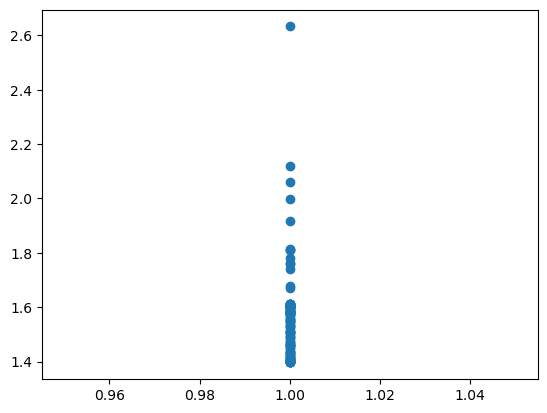

In [215]:
plt.scatter(tot, b_tot)

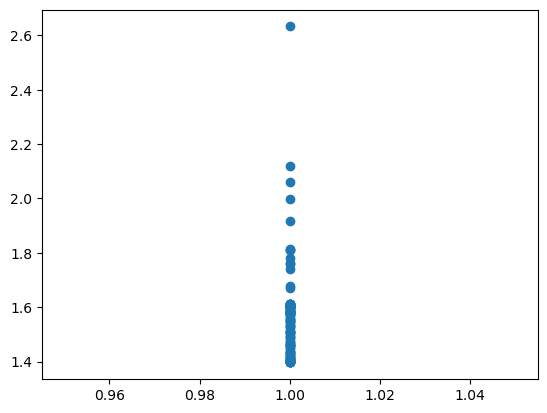

In [206]:
plt.scatter(tot, b_tot/valb)

In [81]:
a1 = limdrift2(np.real(g1b.T), valb)

In [82]:
a2 = limdrift(np.real(g1b.T))

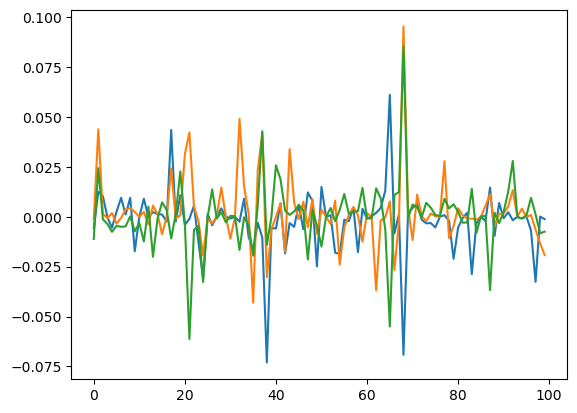

In [89]:
plt.plot(a2)

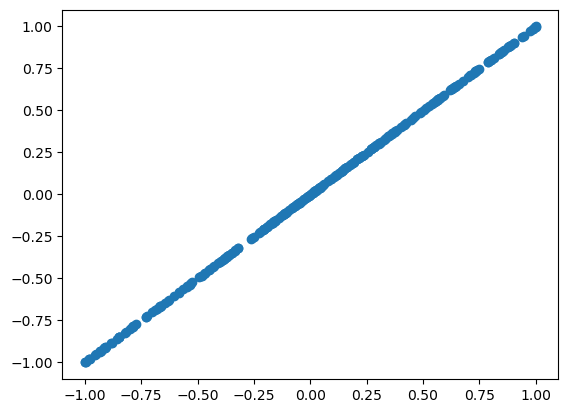

In [93]:
plt.scatter(g1, g1b/np.tile(valb, (3,1)))

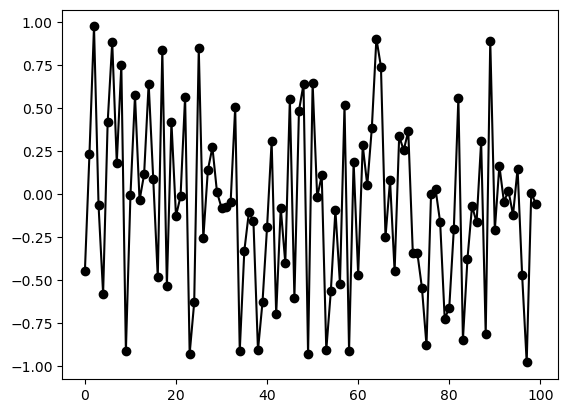

In [99]:
plt.plot(g1[0,:], '-ok')